FMCG Sales Data for Time Series Forecasting and Decision Analysis

# Problem Background
 In the fast-paced world of Fast-Moving Consumer Goods (FMCG), understanding sales dynamics can be the difference between a product flying off the shelves or gathering dust. 
 This dataset offers a glimpse into the intricate dance of sales volume, pricing, promotions, and more across various store locations.

# Problem Definition
Use the data to predict sales volume based on other features provided.


# Data 
  https://www.kaggle.com/datasets/krishanukalita/fmcg-sales-demand-forecasting-and-optimization/data




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import ml libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

from sklearn.tree import export_graphviz

In [2]:
df = pd.read_csv('extended_fmcg_demand_forecasting.csv', parse_dates=['Date'])
df.head()

,Date,Product_Category,Sales_Volume,Price,Promotion,Store_Location,Weekday,Supplier_Cost,Replenishment_Lead_Time,Stock_Level
0,2022-01-01,Household,1583,5.190661,0,Urban,5,9.299281,9,207
1,2022-01-02,Personal Care,1103,8.949596,0,Urban,6,13.274109,5,253
2,2022-01-03,Dairy,455,4.867987,0,Rural,0,13.302265,9,245
3,2022-01-04,Personal Care,1107,16.968596,1,Urban,1,10.056158,5,265
4,2022-01-05,Personal Care,1447,4.309673,1,Rural,2,3.562862,8,334


In [3]:
df.columns

Index(['Date', 'Product_Category', 'Sales_Volume', 'Price', 'Promotion',
       'Store_Location', 'Weekday', 'Supplier_Cost', 'Replenishment_Lead_Time',
       'Stock_Level'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     1000 non-null   datetime64[ns]
 1   Product_Category         1000 non-null   object        
 2   Sales_Volume             1000 non-null   int64         
 3   Price                    1000 non-null   float64       
 4   Promotion                1000 non-null   int64         
 5   Store_Location           1000 non-null   object        
 6   Weekday                  1000 non-null   int64         
 7   Supplier_Cost            1000 non-null   float64       
 8   Replenishment_Lead_Time  1000 non-null   int64         
 9   Stock_Level              1000 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 78.2+ KB


##### Checking for missing values if any

In [5]:
df.isna().sum()

Date                       0
Product_Category           0
Sales_Volume               0
Price                      0
Promotion                  0
Store_Location             0
Weekday                    0
Supplier_Cost              0
Replenishment_Lead_Time    0
Stock_Level                0
dtype: int64

#### Observing for trends 

##### 1.) What is the trends across the years of operations 

In [6]:
df['Year'] = df.Date.dt.year
df['Month'] = df.Date.dt.month
df.head()

,Date,Product_Category,Sales_Volume,Price,Promotion,Store_Location,Weekday,Supplier_Cost,Replenishment_Lead_Time,Stock_Level,Year,Month
0,2022-01-01,Household,1583,5.190661,0,Urban,5,9.299281,9,207,2022,1
1,2022-01-02,Personal Care,1103,8.949596,0,Urban,6,13.274109,5,253,2022,1
2,2022-01-03,Dairy,455,4.867987,0,Rural,0,13.302265,9,245,2022,1
3,2022-01-04,Personal Care,1107,16.968596,1,Urban,1,10.056158,5,265,2022,1
4,2022-01-05,Personal Care,1447,4.309673,1,Rural,2,3.562862,8,334,2022,1


In [7]:
df['Sales_Value'] = df['Sales_Volume'] * df['Price']

In [8]:
df[['Year','Sales_Value']].groupby('Year').sum()

,Sales_Value
Year,
2022,3.946744e+06
2023,3.889008e+06
2024,3.003999e+06


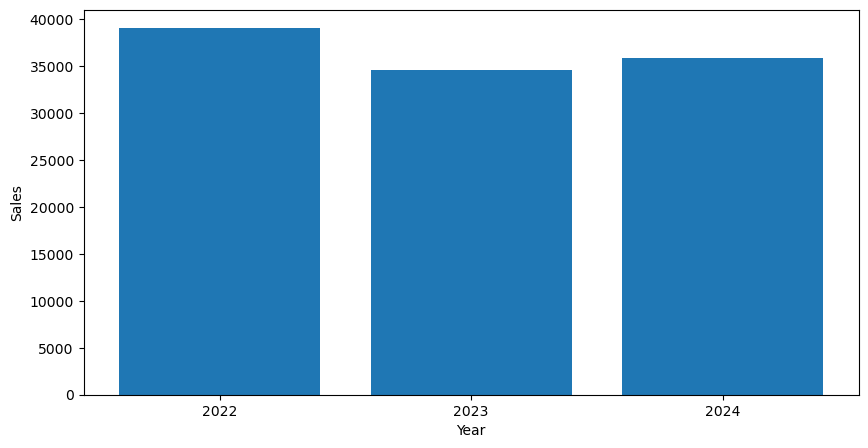

In [9]:
plt.figure(figsize = (10,5))
bars = plt.bar(df['Year'],df['Sales_Value'])
plt.xticks(df['Year'].unique(),['2022','2023','2024'])
# plt.grid(True)
plt.ylabel('Sales')
plt.xlabel('Year')

# for bar in bars.patches:
#   plt.annotate(s = bar.get_height(), xy = (bar.get_x() + bar.get_width() / 2, bar.get_height()), va = "bottom", ha = "center")
  
plt.show()


In [10]:
month_group = df[['Year','Month','Sales_Value']].groupby(['Year','Month']).sum()

### Feature Engineering

In [11]:
data = df.copy()

In [12]:
data['Year'] = data.Date.dt.year
data['Month'] = data.Date.dt.month
data.head()

,Date,Product_Category,Sales_Volume,Price,Promotion,Store_Location,Weekday,Supplier_Cost,Replenishment_Lead_Time,Stock_Level,Year,Month,Sales_Value
0,2022-01-01,Household,1583,5.190661,0,Urban,5,9.299281,9,207,2022,1,8216.816954
1,2022-01-02,Personal Care,1103,8.949596,0,Urban,6,13.274109,5,253,2022,1,9871.404371
2,2022-01-03,Dairy,455,4.867987,0,Rural,0,13.302265,9,245,2022,1,2214.934234
3,2022-01-04,Personal Care,1107,16.968596,1,Urban,1,10.056158,5,265,2022,1,18784.235461
4,2022-01-05,Personal Care,1447,4.309673,1,Rural,2,3.562862,8,334,2022,1,6236.097403


In [13]:
# Dropping date column
data.drop("Date", axis = 1, inplace=True)
data.head()

,Product_Category,Sales_Volume,Price,Promotion,Store_Location,Weekday,Supplier_Cost,Replenishment_Lead_Time,Stock_Level,Year,Month,Sales_Value
0,Household,1583,5.190661,0,Urban,5,9.299281,9,207,2022,1,8216.816954
1,Personal Care,1103,8.949596,0,Urban,6,13.274109,5,253,2022,1,9871.404371
2,Dairy,455,4.867987,0,Rural,0,13.302265,9,245,2022,1,2214.934234
3,Personal Care,1107,16.968596,1,Urban,1,10.056158,5,265,2022,1,18784.235461
4,Personal Care,1447,4.309673,1,Rural,2,3.562862,8,334,2022,1,6236.097403


In [14]:

data['Stock_Status'] = data['Replenishment_Lead_Time'].apply(lambda x: 'Overstocked' if x >= 5.5 else 'Understocked')
data.head(10)

,Product_Category,Sales_Volume,Price,Promotion,Store_Location,Weekday,Supplier_Cost,Replenishment_Lead_Time,Stock_Level,Year,Month,Sales_Value,Stock_Status
0,Household,1583,5.190661,0,Urban,5,9.299281,9,207,2022,1,8216.816954,Overstocked
1,Personal Care,1103,8.949596,0,Urban,6,13.274109,5,253,2022,1,9871.404371,Understocked
2,Dairy,455,4.867987,0,Rural,0,13.302265,9,245,2022,1,2214.934234,Overstocked
3,Personal Care,1107,16.968596,1,Urban,1,10.056158,5,265,2022,1,18784.235461,Understocked
4,Personal Care,1447,4.309673,1,Rural,2,3.562862,8,334,2022,1,6236.097403,Overstocked
5,Snacks,1256,19.254830,1,Urban,3,13.013454,1,245,2022,1,24184.067081,Understocked
6,Dairy,987,8.902240,0,Suburban,4,13.348355,7,356,2022,1,8786.510837,Overstocked
7,Dairy,1928,17.078661,0,Rural,5,3.351477,4,201,2022,1,32927.657537,Understocked
8,Dairy,1963,12.946532,1,Rural,6,11.192678,5,63,2022,1,25414.041425,Understocked
9,Personal Care,226,14.971656,1,Urban,0,4.654533,6,374,2022,1,3383.594182,Overstocked


### Data Preprocessing
 - Converting Categorical variables to numerical

In [15]:
data.select_dtypes(["object"])

,Product_Category,Store_Location,Stock_Status
0,Household,Urban,Overstocked
1,Personal Care,Urban,Understocked
2,Dairy,Rural,Overstocked
3,Personal Care,Urban,Understocked
4,Personal Care,Rural,Overstocked
...,...,...,...
995,Snacks,Suburban,Overstocked
996,Beverages,Urban,Understocked
997,Beverages,Suburban,Overstocked
998,Household,Suburban,Overstocked


In [16]:
data['Product_Category'].value_counts()

Beverages        210
Household        206
Personal Care    204
Dairy            190
Snacks           190
Name: Product_Category, dtype: int64

In [17]:
data['Store_Location'].value_counts()


Urban       342
Rural       338
Suburban    320
Name: Store_Location, dtype: int64

In [18]:
data['Product_Category_cat'] = data['Product_Category'].astype('category').cat.codes
data['Store_Location_cat'] = data['Store_Location'].astype('category').cat.codes
data['Store_Stock_Status_cat'] = data['Stock_Status'].astype('category').cat.codes
data.head()

,Product_Category,Sales_Volume,Price,Promotion,Store_Location,Weekday,Supplier_Cost,Replenishment_Lead_Time,Stock_Level,Year,Month,Sales_Value,Stock_Status,Product_Category_cat,Store_Location_cat,Store_Stock_Status_cat
0,Household,1583,5.190661,0,Urban,5,9.299281,9,207,2022,1,8216.816954,Overstocked,2,2,0
1,Personal Care,1103,8.949596,0,Urban,6,13.274109,5,253,2022,1,9871.404371,Understocked,3,2,1
2,Dairy,455,4.867987,0,Rural,0,13.302265,9,245,2022,1,2214.934234,Overstocked,1,0,0
3,Personal Care,1107,16.968596,1,Urban,1,10.056158,5,265,2022,1,18784.235461,Understocked,3,2,1
4,Personal Care,1447,4.309673,1,Rural,2,3.562862,8,334,2022,1,6236.097403,Overstocked,3,0,0


In [19]:
data.drop(['Product_Category','Store_Location'], axis = 1, inplace=True)

In [20]:
data.head()

,Sales_Volume,Price,Promotion,Weekday,Supplier_Cost,Replenishment_Lead_Time,Stock_Level,Year,Month,Sales_Value,Stock_Status,Product_Category_cat,Store_Location_cat,Store_Stock_Status_cat
0,1583,5.190661,0,5,9.299281,9,207,2022,1,8216.816954,Overstocked,2,2,0
1,1103,8.949596,0,6,13.274109,5,253,2022,1,9871.404371,Understocked,3,2,1
2,455,4.867987,0,0,13.302265,9,245,2022,1,2214.934234,Overstocked,1,0,0
3,1107,16.968596,1,1,10.056158,5,265,2022,1,18784.235461,Understocked,3,2,1
4,1447,4.309673,1,2,3.562862,8,334,2022,1,6236.097403,Overstocked,3,0,0


### Modelling
- Splitting dataset

In [21]:
data = df.copy()

In [24]:
data.columns

Index(['Date', 'Product_Category', 'Sales_Volume', 'Price', 'Promotion',
       'Store_Location', 'Weekday', 'Supplier_Cost', 'Replenishment_Lead_Time',
       'Stock_Level', 'Year', 'Month', 'Sales_Value'],
      dtype='object')

In [23]:
X = data.drop('Stock_Status', axis = 1)
y = data['Stock_Status']

KeyError: "['Stock_Status'] not found in axis"

In [ ]:
# Slitting the data (70% for training and 30% for testing).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

y_test_actual = y_test


- Scaling data

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [ ]:
from sklearn.tree import DecisionTreeClassifier

linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled,y_train)

### Train the Model
- Linear Regression Model

In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled,y_train)

NameError: name 'X_train_scaled' is not defined

In [ ]:
# The intercept and co-efficient for each column in our training dataset.
pd.DataFrame(data = np.append(linear_reg.intercept_ , linear_reg.coef_), index = ['Intercept']+[col+" Coef." for col in X.columns], columns=['Value']).sort_values('Value', ascending=False)


,Value
Intercept,1054.492857
Store_Location_cat Coef.,29.865217
Supplier_Cost Coef.,18.788800
Replenishment_Lead_Time Coef.,17.341933
Year Coef.,12.390000
Promotion Coef.,11.791360
Weekday Coef.,1.031398
Stock_Level Coef.,-4.485650
Month Coef.,-11.031190
Price Coef.,-12.739335


In [ ]:
# Evaluating the model

def model_evaluation(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score = metrics.r2_score(y_test, y_pred)

    return pd.DataFrame([MAE, MSE, RMSE, R2_Score], index=['MAE', 'MSE', 'RMSE' ,'R2-Score'], columns=[model_name])

model_evaluation(linear_reg, X_test_scaled, y_test, 'Linear Reg.')

,Linear Reg.
MAE,460.271833
MSE,287471.096887
RMSE,536.163312
R2-Score,0.004209


ValueError: x and y must be the same size

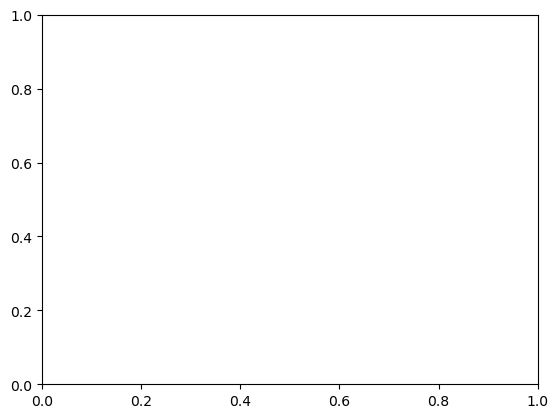

In [ ]:
plt.scatter(y_train,X_train_scaled)
# plt.plot(X, linear_reg.predict(X_test))
plt.show()

In [ ]:
y_test_pred = linear_reg.predict(X_test_scaled)
df_comp = pd.DataFrame({'Actual':y_test_actual, 'Predicted':y_test_pred})

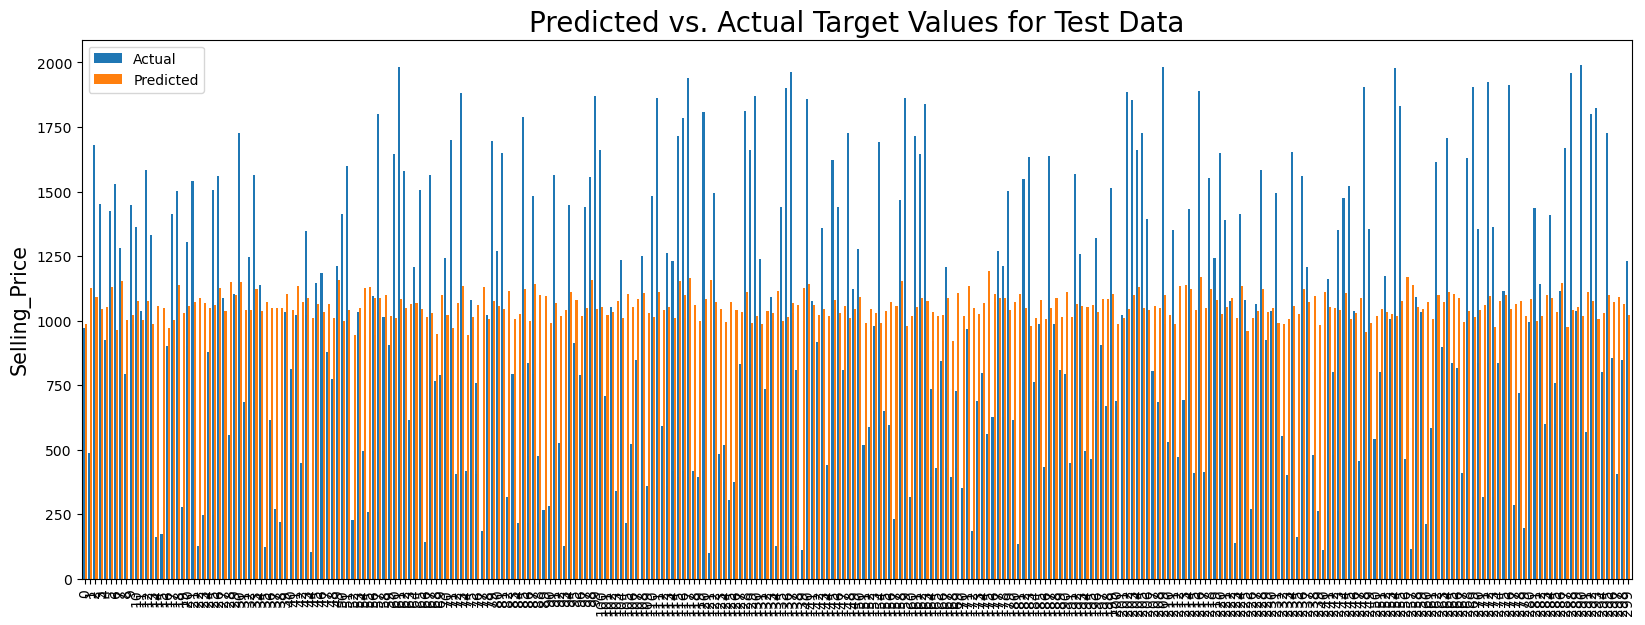

In [ ]:
def compare_plot(df_comp):
    df_comp.reset_index(inplace=True)
    df_comp.plot(y=['Actual','Predicted'], kind='bar', figsize=(20,7), width=0.8)
    plt.title('Predicted vs. Actual Target Values for Test Data', fontsize=20)
    plt.ylabel('Volumes', fontsize=15)
    plt.show()

compare_plot(df_comp)